In [1]:
!git clone https://github.com/haoweiwang0/Coreset_Prioritization.git
%cd Coreset_Prioritization

Cloning into 'Coreset_Prioritization'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 43 (delta 21), reused 25 (delta 11), pack-reused 0
Receiving objects: 100% (43/43), 783.85 KiB | 12.25 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/Coreset_Prioritization


In [2]:
!pip install neural-tangents

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install -U "jax[cuda12]"

Accuracy: 0.9916666666666667


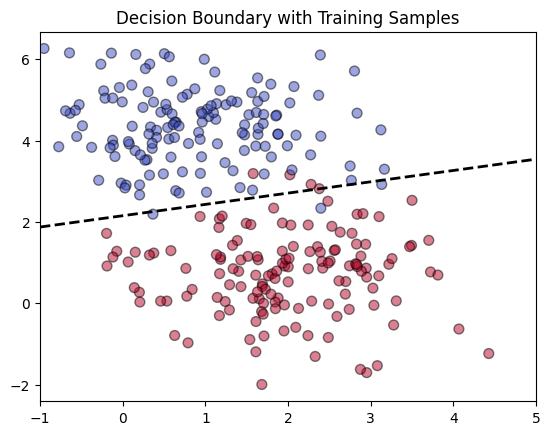

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 生成合成的二维数据集
X, y = make_blobs(n_samples=400, centers=2, cluster_std=0.95, random_state=0)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 训练模型
model = LogisticRegression()
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# 可视化结果
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', s=50, alpha=0.5, edgecolor='k')

# 可视化决策边界
x_values = np.linspace(-1, 5, 10)
y_values = -(model.coef_[0][0] * x_values + model.intercept_) / model.coef_[0][1]
plt.plot(x_values, y_values, c='k', linestyle='dashed', linewidth=2)

plt.xlim(-1, 5)
plt.title('Decision Boundary with Training Samples')
plt.show()

In [38]:
import torch

def cross_entropy(K, alpha, y, weights, lmbda):
    loss = torch.nn.CrossEntropyLoss(reduction='none')
    loss_value = torch.mean(loss(torch.matmul(K, alpha), y.float()) * weights)
    if lmbda > 0:
        loss_value += lmbda * torch.trace(torch.matmul(alpha.T, torch.matmul(K, alpha)))
    return loss_value

In [48]:
import bilevel_coreset

lr_kernel = lambda x1, x2: np.dot(x1, x2.T)

bc = bilevel_coreset.BilevelCoreset(outer_loss_fn=cross_entropy,
                                    inner_loss_fn=cross_entropy, out_dim=1, max_outer_it=1,
                                    inner_lr=0.25, max_inner_it=500, logging_period=100)
coreset_inds, _ = bc.build_with_representer_proxy_batch(X, y.reshape(-1, 1), 50, kernel_fn_np=lr_kernel,
                                                        cache_kernel=True, start_size=3, inner_reg=1e-6)

X_coreset = X[coreset_inds]
y_coreset = y[coreset_inds]

In [49]:
# 训练模型
coreset_model = LogisticRegression()
coreset_model.fit(X_coreset, y_coreset)

# 预测测试集
y_coreset_pred = coreset_model.predict(X_test)

# 评估模型
coreset_accuracy = accuracy_score(y_test, y_coreset_pred)
print(f"Coreset Accuracy: {coreset_accuracy}")

Coreset Accuracy: 0.9916666666666667


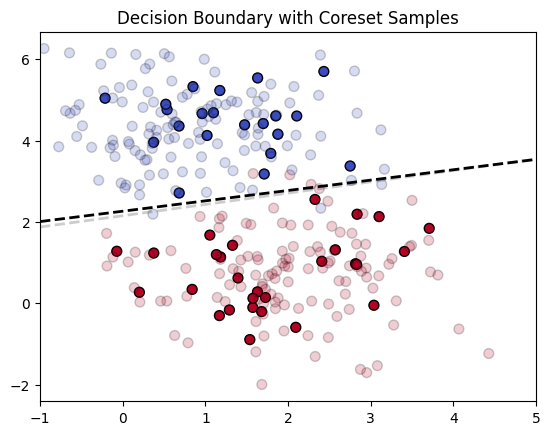

In [50]:
# 可视化结果
plt.scatter(X_coreset[:, 0], X_coreset[:, 1], c=y_coreset, cmap='coolwarm', s=50, alpha=1, edgecolor='k')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', s=50, alpha=0.2, edgecolor='k')

# 可视化决策边界
x_values = np.linspace(-1, 5, 10)
y_values = -(coreset_model.coef_[0][0] * x_values + coreset_model.intercept_) / coreset_model.coef_[0][1]
plt.plot(x_values, y_values, c='k', linestyle='dashed', linewidth=2, alpha=1)
x_values = np.linspace(-1, 5, 10)
y_values = -(model.coef_[0][0] * x_values + model.intercept_) / model.coef_[0][1]
plt.plot(x_values, y_values, c='k', linestyle='dashed', linewidth=2, alpha=0.2)

plt.xlim(-1, 5)
plt.title('Decision Boundary with Coreset Samples')
plt.show()